In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
!pip list

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.12
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.1
altair                             5.5.0
ann

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import cv2
import imghdr

<ipython-input-4-290956b76b78>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
data_dir='/content/drive/MyDrive/Colab Notebooks/hand_data/data'

In [ ]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("ash2703/handsignimages")
data_dir = os.path.join(data_dir, "Train")
print("Path to dataset files:", data_dir)

100%|██████████| 23.1M/23.1M [00:00<00:00, 81.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ash2703/handsignimages/versions/2/Train


In [ ]:
image_exts=['jpeg','jpg','bmp','png']

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path=os.path.join(data_dir,image_class,image)
    try:
      img=cv2.imread(image_path)
      tip=imghdr.what(image_path)
      if tip not in image_exts:
        print('image not in ext list{}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))
      # os.remove(image_path)

KeyboardInterrupt: 

In [ ]:
tf.data.Dataset??

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data=tf.keras.utils.image_dataset_from_directory(data_dir)

Found 27455 files belonging to 24 classes.


In [ ]:
data_iterator=data.as_numpy_iterator()

In [ ]:
batch=data_iterator.next()

In [ ]:
#(batch size,image heigh,image weidth,colored image)
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([ 9,  5, 21, 18,  6, 17, 11,  7,  4, 16,  4, 17,  3, 10, 12, 21, 19,
        2, 12, 22,  1,  7,  6,  3, 23, 14, 20,  8, 16,  6,  5, 10],
      dtype=int32)

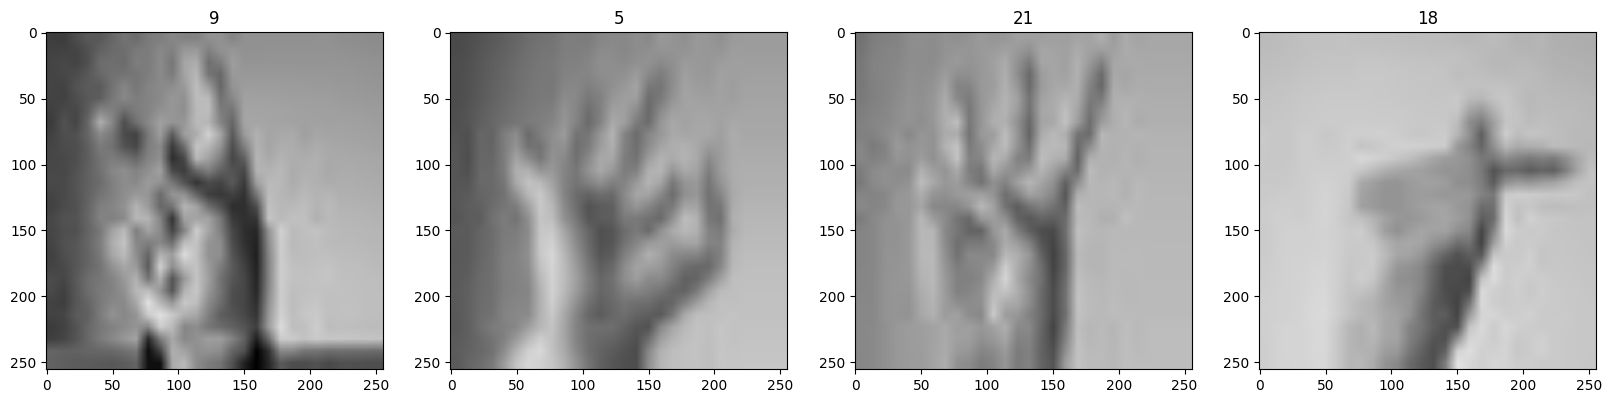

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

2/preprocessing the data

In [ ]:
scaled=batch[0]/255
scaled.min()
scaled.max()

1.0

In [ ]:
data=data.map(lambda x,y:(x/255,y))

In [ ]:
scaled_iterator=data.as_numpy_iterator()

In [ ]:
batch=scaled_iterator.next()

In [ ]:
batch[0].max()

1.0

In [ ]:
len(data)

858

In [ ]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)
test_size=int(len(data)*.1)

In [ ]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [ ]:
len(test)

85

 build the deep learning model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#model=Sequential()
#model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
#model.add(MaxPooling2D())

#model.add(Conv2D(32,(3,3),1,activation='relu'))
#model.add(MaxPooling2D())

#model.add(Conv2D(16,(3,3),1,activation='relu'))
#model.add(MaxPooling2D())

#model.add(Flatten())

#model.add(Dense(256,activation='relu'))
#model.add(Dense(24, activation='softmax'))  # Output layer for 27 classes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Define the upgraded CNN model
model = Sequential([
    # Input shape should match your image dimensions (e.g., 256x256x3 for RGB images)
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to reduce overfitting
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout to reduce overfitting
    BatchNormalization(),

    Dense(24, activation='softmax')  # Output layer for 24 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,0

 Total params: 26,221,528 (100.03 MB)

 Trainable params: 26,219,032 (100.02 MB)

 Non-trainable params: 2,496 (9.75 KB)

training


In [ ]:
logdir="/content/drive/MyDrive/Colab Notebooks/hand_data/logs"

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Define callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
batch_size = 32
hist = model.fit(
    train,
    epochs=5,
    batch_size=batch_size,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback, checkpoint_callback]
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4089 - loss: 2.0901

600/600 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - accuracy: 0.4092 - loss: 2.0889 - val_accuracy: 0.2970 - val_loss: 2.4661 - learning_rate: 0.0010
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8586 - loss: 0.4509

600/600 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.8587 - loss: 0.4507 - val_accuracy: 0.8721 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9096 - loss: 0.2890

600/600 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.9096 - loss: 0.2890 - val_accuracy: 0.9627 - val_loss: 0.1564 - learning_rate: 0.0010
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - accuracy: 0.9345 - loss: 0.1991 - val_accuracy: 0.7749 - val_loss: 0.7509 - learning_rate: 0.0010
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9424 - loss: 0.1767

600/600 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.9424 - loss: 0.1766 - val_accuracy: 0.9971 - val_loss: 0.0300 - learning_rate: 0.0010


In [ ]:
hist.history

{'accuracy': [0.5964583158493042,
  0.8817187547683716,
  0.9147396087646484,
  0.9437500238418579,
  0.9544791579246521],
 'loss': [1.348758578300476,
  0.37772101163864136,
  0.2630515396595001,
  0.17725254595279694,
  0.14421434700489044],
 'val_accuracy': [0.2969663739204407,
  0.8720760345458984,
  0.9627193212509155,
  0.7748538255691528,
  0.9970760345458984],
 'val_loss': [2.466127872467041,
  0.45480525493621826,
  0.15643858909606934,
  0.7508828043937683,
  0.030047006905078888],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513]}

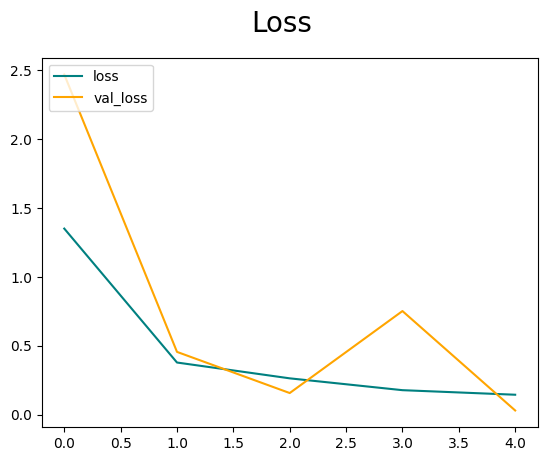

In [ ]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()
#

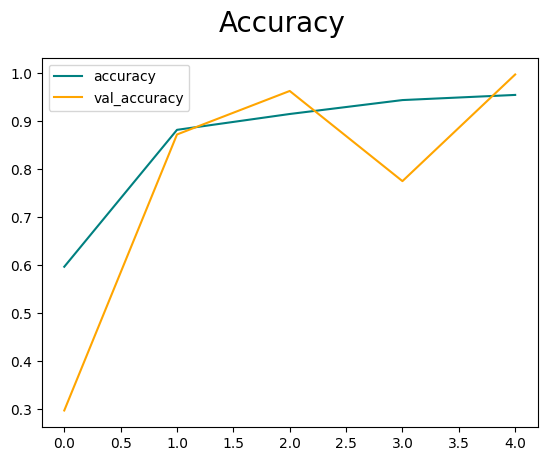

In [ ]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

evaluation

In [ ]:
from tensorflow.keras.metrics import Precision,Recall,SparseCategoricalAccuracy

In [ ]:
pre=Precision()
re=Recall()
acc = SparseCategoricalAccuracy()

In [ ]:
batch=test.as_numpy_iterator().next()
batch[0].shape

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Convert yhat to class indices
    yhat_classes = tf.argmax(yhat, axis=-1)

    # Update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

In [ ]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:1.0,Accuracy:0.0470588244497776


save model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/hand_data','handV2_model.h5'))

In [ ]:
model=load_model(os.path.join('models','/content/drive/MyDrive/Colab Notebooks/hand_data/model/hand_model.h5'))

In [ ]:
import cv2

In [ ]:
img=cv2.imread('/content/image_1739700542.705313.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize=tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
yhat=model.predict(np.expand_dims(resize/255,0))

NameError: name 'resize' is not defined

In [ ]:
yhat

array([[1.5318349e-07, 3.7013390e-06, 3.9003051e-05, 6.1222668e-06,
        6.5572216e-04, 1.0778983e-03, 1.2018592e-07, 1.1458774e-07,
        1.5374557e-04, 3.5323224e-05, 3.9376642e-05, 4.8357805e-07,
        5.9617811e-05, 4.0619190e-05, 6.6529661e-05, 8.2812971e-07,
        2.3999936e-08, 9.9491560e-01, 3.1710361e-04, 1.2122434e-09,
        1.8832632e-04, 6.5426331e-04, 1.2827640e-03, 2.7247675e-04,
        1.4174719e-04, 1.2271607e-08, 4.8340513e-05]], dtype=float32)

In [ ]:
import numpy as np

predicted_class = np.argmax(yhat, axis=-1)
print("Predicted class index:", predicted_class)

Predicted class index: [17]
